# Week 5: Regularization and Hyperparameter Tuning

This week, we take a dive into how to improve the performance of our machine learning models. We will focus on regression problems, where we try to predict a numerical value, but the ideas herein are pretty universal across supervised machine learning.

First, **regularization** methods sometimes help improve a model's ability to make good predictions on the test set, often at the expense of training accuracy. We focus on some methods developed by mathematician Andrey Tikhonov and used for solving ill-posed inverse problems. Some special cases of his methods and new innovations have become incredibly popular in machine learning.

Second, machine learning models we have seen have trainable parameters determined by a learning algorithm, such as the coefficients in linear regression and the shape and prototype parameters in radial basis functions. **Hyperparameters** are numbers we set or decisions we make before running learning algorithms. Wednesday, we focus on effectively making these choices for performance, or **tuning** them.

## Lecture 12: Regularization and Overfitting

The problem of **overfitting** is an issue where a machine learning model fits too strongly to the training data, which reduces its ability to generalize to make good predictions on the test set. High performance on the test set is typically our most important goal, because this measures how the model performs on data it has not seen before, indicating the model should perform well on real-world data, assuming the test data are representative of the data we hope to predict.

Below, we implement ridge regression, which imposes an $L^2$ penalty on the model parameters to minimize the loss function

$$L(\theta) = \|\theta_0 + X\theta - y\| + \lambda_2\|\theta\|^2$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [2]:
class RidgeRegression:
    
    def __init__(self, alpha = 0.001, lambda2 = 0):
        # save variables to object memory
        self.alpha = alpha
        self.lambda2 = lambda2
        
    # fit the model to the data
    def fit(self, X, y, epochs = 1000, update = 100):
        # find the dimension of the data
        d = X.shape[1]
        
        # initialize the model parameters
        self.theta0 = np.random.uniform()
        self.theta = np.random.uniform(size = d)
        
        # compute the means of X and y
        yMean = np.mean(y)
        xMean = np.mean(X, axis = 0)
        
        # standardize the data
        X = scale(X)
        y = scale(y)
        
        # compute a scaling parameter
        eta = np.linalg.norm(X)
        
        # train the model
        for i in range(epochs):
            # compute the predicted y values
            predictions = self.theta0 + X @ self.theta
            
            # compute the error
            error = predictions - y
            
            # compute the sum of squared errors
            sse = np.sum(error ** 2)
            
            # compute the loss
            loss = sse + self.lambda2 * np.linalg.norm(self.theta) ** 2 #+ self.lambda1 * np.sum(np.abs(self.theta))

            # print an update
            if (i + 1) % update == 0:
                print('Epoch', i + 1, '\tLoss', loss)
                                                
            # weight update for the bias
            self.theta -= self.alpha * (X.T @ error + 2 * self.lambda2 * self.theta)
            self.theta0 = yMean - xMean @ self.theta

    # predict the output from input (testing) data
    def predict(self, X):
        # return the predicted outputs
        return self.theta0 + X @ self.theta

Let's test it on a small, simple dataset to check that it works.

Epoch 10 	Loss 45.48346562073978
Epoch 20 	Loss 23.670366633568364
Epoch 30 	Loss 12.174879265095795
Epoch 40 	Loss 6.528409812587276
Epoch 50 	Loss 4.1203887883603185
Epoch 60 	Loss 3.441580532140384
Epoch 70 	Loss 3.6321674298625077
Epoch 80 	Loss 4.212593783807319
Epoch 90 	Loss 4.923839150995452
Epoch 100 	Loss 5.6330864403394045
The predicted y values are [2.11481951 2.35740975 2.6        2.84259025 3.08518049]
The real y values are [1 2 3 3 4]
The theta values are [0.65927803 0.24259025]
The r^2 score is 0.5399544552700626
The mean squared error is 0.478447366519135
The mean absolute error is 0.5888917050692032


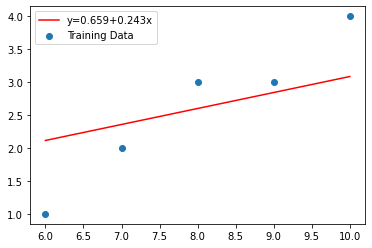

In [7]:
X = np.array([[6], [7], [8], [9], [10]])
y = np.array([1, 2, 3, 3, 4])

model = RidgeRegression(lambda2 = 10)
model.fit(X, y, epochs = 100, update = 10)
predictions = model.predict(X)

# print the predictions
print('The predicted y values are', predictions)

# print the real y values
print('The real y values are', y)

# print the beta values
parameters = np.concatenate((np.atleast_1d(model.theta0), model.theta))
print('The theta values are', parameters)

# plot the training points
plt.scatter(X, y, label = 'Training Data')

# plot the fitted model with the training data
xModel = np.linspace(6,10,100)
yModel = parameters[0] + parameters[1]*xModel
lineFormula = 'y={:.3f}+{:.3f}x'.format(parameters[0], parameters[1])
plt.plot(xModel, yModel, 'r', label = lineFormula)

# add a legend
plt.legend()

# return quality metrics
print('The r^2 score is', r2_score(y, predictions))
print('The mean squared error is', mean_squared_error(y, predictions))
print('The mean absolute error is', mean_absolute_error(y, predictions))

## Lecture 12: Hyperparameter Tuning and Cross-Validation

As our models grow in complexity, we have added a number of hyperparameters to various models, including learning rate, $L^1$ and $L^2$ penalty coefficients, numbers of prototype points in radial basis functions (RBFs) or number of basis functions in linear basis functions (LBFs), and so on, that we need to test models with different hyperparameter settings to see what hyperparameters are effective.

However, if we continue with just splitting data into training and test splits and testing all these different models on the same test set, we are undoing the purpose of the train/test split--to test a model on data it has never seen. Here, we are looking at the test set over and over until a model fits well to it, which is not an effective test of performance on new data. Beyond that, we risk overfitting, where the model works well on the data we use, but fails to effectively generalize to truly new data.

**Cross-validation** is any of a number of methods for assessing how well a model will generalize to a new data set.

The simplest form of cross-validation is to randomly split the data into three subsets:

* Training set
* Development set (sometimes called the "dev" set or validation set)
* Testing set

And following the procedure for **tuning hyperparameters**:

1. Choose some settings for the hyperparameters.
2. Train the model on the training set.
3. Test the model on the dev set.
4. Go back to step 1 until you are satisfied with the hyperparameters.
5. Test the model with the hyperparameters chosen on the test set.

It is very possible to make this procedure more sophisticated in useful ways by, for example, doing some sort of automated search of the hyperparameter space in steps 1-4. If there are not too many hyperparameters and the model is not computationally expensive to train and test, you can do a grid search via nested loops.

This method of cross-validation is recommended when the number of datapoints in the training set is large compared to the dimension of the data. There are no rules set in stone, but a common train/dev/test split is 60\%/20\%/20\% for datasets with hundreds or thousands of datapoints. However, for huge datasets of millions of datapoints, it has been suggested that much smaller dev and test sets are good enough.